# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

<a id='intro'></a>

## Оглавление

[Введение](#chapter2)

[Подготовка данных](#chapter3)

[Исследование задачи](#chapter4)

[Борьба с дисбалансом](#chapter5)

[Тестирование модели](#chapter6)

[Общий вывод](#chapter7)

<a id='chapter2'></a>

# Введение


Цель данной работы: спрогнозировать уход клиента из банка. Для решения этой задачи мы должны построить модель для задачи классификации, которая сможет определить уйдет данный клиент из банка или нет.

В качестве исходной информации нам передали данные о поведении клиентов и расторжении договоров с банком.


[К оглавлению](#intro)

<a id='chapter3'></a>

# 1. Подготовка данных


Загрузим переданный файл с данными в проект и посмотрим информацию по нему.


In [1]:
#загрузка необходимых библиотек
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#загрузка файла с данными и просмотр пяти первых строк таблицы
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
#просмотр информации о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB



Перед нами таблица с данными, содержащая 14 столбцов:

* <i> RowNumber</i> - индекс строки;

* <i> CustomerId</i> - уникальный идентификатор клиента;

* <i> Surname</i> - фамилия клиента;

* <i> CreditScore</i> - кредитный рейтинг;

* <i> Geography</i> - страна проживания;

* <i> Gender</i> - пол клиента;

* <i> Age</i> - возраст клиента;

* <i> Tenure</i> - количество недвижимости;

* <i> Balance</i> - баланс на счете;

* <i> NumOfProducts</i> - количество продуктов банка, используемых клиентом;

* <i> HasCrCard</i> - наличие кредитной карты;

* <i> IsActiveMember</i> - активность клиента;

* <i> EstimatedSalary</i> - предполагаемая зарплата;

* <i> Exited</i> - факт ухода клиента.



Проведем небольшую предобработку данных. Проверим данные на наличие пропусков и дубликатов.


In [4]:
#проверка пропусков
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [5]:
#проверка количества дубликатов
data.duplicated().sum()

0


Пропуски в столбце <i>Tenure</i>, вероятно, связаны с тем, что у клиента нет недвижимости. Можем заполнить их нулями.


In [6]:
#замена пропусков
data.loc[data['Tenure'].isna(), 'Tenure'] = 0


Выделим среди данных целевой признак - в данном случае это столбец <i>Exited</i>.

Для решения поставленной задачи нам не нужны все эти столбцы. К примеру, нам не потребуются первые три столбца - они никак не влияют на желание клиента расторгнуть договор с банком, можем не учитывать их в обучающем наборе.


In [7]:
#объявление признаков
target = data['Exited']
feature = data.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis=1)

In [8]:
feature.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,650.528800,38.921800,4.543400,76485.889288,1.530200,0.70550,0.515100,100090.239881
std,96.653299,10.487806,3.111573,62397.405202,0.581654,0.45584,0.499797,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000
50%,652.000000,37.000000,4.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000


In [9]:
feature['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [10]:
feature['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)


Значения признаков выглядят правдоподобно - нет таких артефактов, как отрицательные значения или возраста клиента, меньше 18 лет. Столбец с полом клиента принимает только два значения: мужской и женский.


### Вывод


Итак, на данном шаге мы загрузили исходные данные и провели их предобработку. Для решения задачи прогноза оттока клиентов мы выделили целевой признак - столбец <i>Exited</i> - факт ухода клиента - и обучающий набор признаков, такие как количество недвижимости у клиента, баланс на счете и прочие. Перед нами задача классификации, т.е. тип целевого признака категориальный: он принимает только значения 0 или 1 (клиент ушел). В обучающем наборе есть как категориальные признаки: пол, страна проживания, так и численные: баланс на счете, зарплата.


[К оглавлению](#intro)

<a id='chapter4'></a>

# 2. Исследование задачи


Сейчас нам нужно подготовить данные перед обучением модели. Обучить модель на тех данных, что у нас есть, не получится: признаки могут быть только численные, а наши данные содержат и категориальные признаки. Преобразуем их в численные техникой прямого кодирования.


In [11]:
feature = pd.get_dummies(feature, columns=['Gender', 'Geography'], drop_first=True)
feature.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1



Теперь у нас появился новый столбец, вместо <i>Gender</i> - <i>Gender_Male</i>, который принимает значение 0 (клиент женского пола) или 1 (клиент мужского пола). А также два столбца со страной проживания - Германия или Испания. Если значения в них равны 0, то страна проживания - Франция.



Тестовой выборки для предсказывания значений у нас нет. Поэтому необходимо общий набор данных разделить на три части: обучающую выборку, валидационную и тестовую в соотношении 3:1:1.

На обучающей выборке мы обучим модель, на валидационной - проверочной - подберем параметры.


In [12]:
#выделим тестовую выборку
data_features, features_test, data_target, target_test = (
train_test_split(feature, target, test_size=0.2, random_state=0)
)
#выделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = (
train_test_split(data_features, data_target, test_size=0.25, random_state=0)
)
print('Количество объектов в обучающей выборке:', len(features_train))
print('Количество объектов в валидационной выборке:', len(features_valid))
print('Количество объектов в тестовой выборке:', len(features_test))

Количество объектов в обучающей выборке: 6000
Количество объектов в валидационной выборке: 2000
Количество объектов в тестовой выборке: 2000


In [13]:
print('Значений класса "1" в обучающей выборке: {:.1%}'.format(target_train.sum()/len(target_train)))
print('Значений класса "1" в валидационной выборке: {:.1%}'.format(target_valid.sum()/len(target_valid)))
print('Значений класса "1" в тестовой выборке: {:.1%}'.format(target_test.sum()/len(target_test)))

Значений класса "1" в обучающей выборке: 20.2%
Значений класса "1" в валидационной выборке: 20.8%
Значений класса "1" в тестовой выборке: 20.2%



В значениях целевого признака наблюдается сильный дисбаланс классов - значений класса "1" в четыре раза меньше, чем значений класса "0". В данном разделе попробуем обучить модель без учета дисбаланса.



Теперь, после разделения набора данных на три выборки, нам необходимо масштабировать признаки. Если в одном столбце значения и их разбросы больше, чем в другом, то алгоритм решит, что этот признак важнее, а это не так: все признаки важны.


In [14]:
#численные признаки
numeric = ['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'EstimatedSalary']
#масштабирование
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
8997,0.614238,-0.568058,-1.442526,0.00,0.803737,1,0,-0.470238,0,0,0
2295,0.500880,0.100058,0.813771,0.00,-0.930947,0,1,0.917127,1,0,0
6793,-0.282322,1.054511,0.813771,126608.37,-0.930947,0,1,-1.725150,1,1,0
2071,0.366911,-0.281722,0.169115,0.00,0.803737,1,1,0.918915,0,0,1
6344,2.056978,0.195504,-0.475542,0.00,0.803737,1,0,0.500839,1,0,0



В данный момент нам известны три алгоритма классификации:

* дерево решений

* случайный лес

* логистическая регрессия



Построим модель с предельно большим значением F1-меры.


### Дерево решений


Построим модель с помощью дерева решений и подберем глубину дерева с наилучшим значением F1-меры.


In [15]:
#функция построения модели дерева решений
def Tree(features_train, target_train, features_valid, target_valid):
    #зададим переменные, в которые сохраним наилучшие результаты
    best_depth_tree = 0
    best_result_tree = 0
    #создадим пустой датафрейм, с помощью которого потом построим график
    model_tree = pd.DataFrame(columns=['depth', 'result'])
    #в цикле перебираем значения глубины дерева
    for depth in range(1, 11):
        #задаем модель с текущей глубиной
        model = DecisionTreeClassifier(random_state=0, max_depth=depth)
        #обучаем модель на обучающей выборке
        model.fit(features_train, target_train)
        #предсказываем результаты на валидационной выборке
        predictions = model.predict(features_valid)
        #рассчитываем значение F1
        result = f1_score(target_valid, predictions)
        model_tree.loc[depth-1, 'depth'] = depth
        model_tree.loc[depth-1, 'result'] = result
        #выбираем наилучший результат
        if result > best_result_tree:
            best_result_tree = result
            best_depth_tree = depth
    return best_depth_tree, best_result_tree, model_tree

In [16]:
best_depth_tree, best_result_tree, model_tree = Tree(features_train, target_train, features_valid, target_valid)
print('Наилучшая F1-мера:', best_result_tree, 'с глубиной', best_depth_tree)

Наилучшая F1-мера: 0.5915915915915916 с глубиной 5


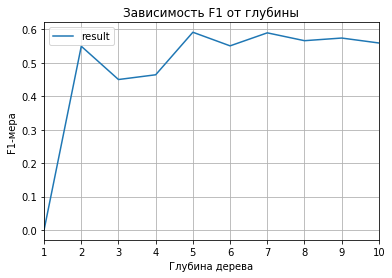

In [17]:
#построим график зависимости F1-меры от глубины дерева
model_tree.plot(x='depth', y='result', grid=True)
plt.title('Зависимость F1 от глубины')
plt.xlabel('Глубина дерева')
plt.ylabel('F1-мера')
plt.show()

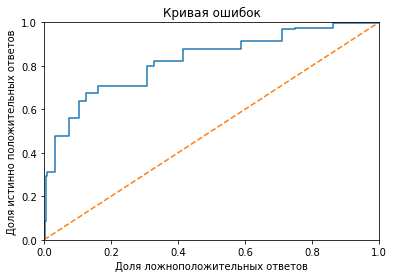

AUC-ROC: 0.8463266026471307


In [18]:
model = DecisionTreeClassifier(random_state=0, max_depth=best_depth_tree)
model.fit(features_train, target_train)
probabilities = model.predict_proba(features_valid)
proba_one_valid = probabilities[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, proba_one_valid)
plt.figure()
plt.step(fpr, tpr, where='post')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('Доля ложноположительных ответов')
plt.ylabel('Доля истинно положительных ответов')
plt.title('Кривая ошибок')
plt.show()
auc_roc_tree = roc_auc_score(target_valid, proba_one_valid)
print('AUC-ROC:', auc_roc_tree)


Значение площади под кривой ошибок довольно высокое - 0.85.


### Случайный лес


Построим модель с помощью алгоритма "случайный лес". При этом варьировать будем два гиперпараметра - глубину дерева и количество деревьев.


In [19]:
#функция построения модели случайного леса
def Forest(features_train, target_train, features_valid, target_valid):
    #зададим переменные, в которые сохраним наилучшие результаты
    best_est_forest = 0
    best_depth_forest = 0
    best_result_forest = 0
    #в цикле перебираем значения глубины дерева и количества деревьев
    for est in range(10, 51, 5):
        for depth in range(1, 11):
            #задаем модель с текущей глубиной
            model = RandomForestClassifier(random_state=0, n_estimators=est, max_depth=depth)
            #обучаем модель на обучающей выборке
            model.fit(features_train, target_train)
            #предсказываем результаты на валидационной выборке
            predictions = model.predict(features_valid)
            #рассчитываем значение F1
            result = f1_score(target_valid, predictions)
            #выбираем наилучший результат
            if result > best_result_forest:
                best_result_forest = result
                best_depth_forest = depth
                best_est_forest = est
    return best_depth_tree, best_result_tree, best_est_forest

In [20]:
best_depth_forest, best_result_forest, best_est_forest = Forest(features_train, target_train, features_valid, target_valid)
print('Наилучшая F1-мера:', best_result_forest, 'с глубиной', best_depth_forest, 'и количеством деревьев', best_est_forest)

Наилучшая F1-мера: 0.5915915915915916 с глубиной 5 и количеством деревьев 10


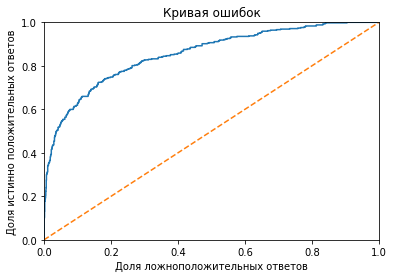

AUC-ROC: 0.8548797096245934


In [21]:
model = RandomForestClassifier(random_state=0, max_depth=best_depth_forest, n_estimators=best_est_forest)
model.fit(features_train, target_train)
probabilities = model.predict_proba(features_valid)
proba_one_valid = probabilities[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, proba_one_valid)
plt.figure()
plt.step(fpr, tpr, where='post')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('Доля ложноположительных ответов')
plt.ylabel('Доля истинно положительных ответов')
plt.title('Кривая ошибок')
plt.show()
auc_roc_forest = roc_auc_score(target_valid, proba_one_valid)
print('AUC-ROC:', auc_roc_forest)

### Логистическая регрессия


Построим еще одну модель с помощью алгоритма логистической регрессии.


In [22]:
#создаем модель логистической регрессии
model = LogisticRegression(random_state=0, solver='liblinear')
#обучаем модель
model.fit(features_train, target_train)
#предсказываем результаты на валидационной выборке
predictions = model.predict(features_valid)
#рассчитываем F1-меру
result_logistic = f1_score(target_valid, predictions)
print('Наилучшая F1-мера:', result_logistic)

Наилучшая F1-мера: 0.0047619047619047615


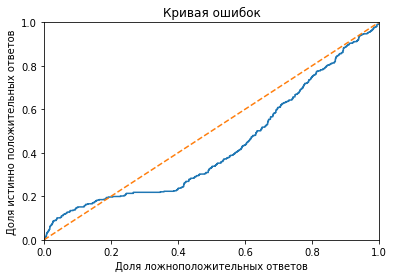

AUC-ROC: 0.4296716764301761


In [23]:
probabilities = model.predict_proba(features_valid)
proba_one_valid = probabilities[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, proba_one_valid)
plt.figure()
plt.step(fpr, tpr, where='post')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('Доля ложноположительных ответов')
plt.ylabel('Доля истинно положительных ответов')
plt.title('Кривая ошибок')
plt.show()
auc_roc_log = roc_auc_score(target_valid, proba_one_valid)
print('AUC-ROC:', auc_roc_log)

In [24]:
#создаем результирующую таблицу
final = pd.DataFrame(index=['Дерево решений', 'Случайный лес', 'Логистическая регрессия'], columns=['F1', 'AUC-ROC'])
final.loc['Дерево решений', 'F1'] = best_result_tree
final.loc['Дерево решений', 'AUC-ROC'] = auc_roc_tree
final.loc['Случайный лес', 'F1'] = best_result_forest
final.loc['Случайный лес', 'AUC-ROC'] = auc_roc_forest
final.loc['Логистическая регрессия', 'F1'] = result_logistic
final.loc['Логистическая регрессия', 'AUC-ROC'] = auc_roc_log

### Вывод


Подведем итог по проведенному анализу моделей.


In [25]:
final.head().style.highlight_max(color='yellowgreen', subset=['F1', 'AUC-ROC'])

,F1,AUC-ROC
Дерево решений,0.591592,0.846327
Случайный лес,0.591592,0.85488
Логистическая регрессия,0.0047619,0.429672



Дерево решений и случайный лес показывают одинаковую F1-меру, но значение AUC-ROC у алгоритма случайного леса выше.


[К оглавлению](#intro)

<a id='chapter5'></a>

# 3. Борьба с дисбалансом


В этой части мы попробуем улучшить качество моделей, учитывая дисбаланс классов. Для этого увеличим выборку техникой upsampling и уменьшим выборку методом downsampling.


### Увеличение выборки


* разделим обучающую выборку на отрицательные и положительные объекты

* скопируем четыре раза положительные объекты

* с учетом полученных данных создадим новую выборку

* перемешаем данные


In [26]:
#функция upsampling
def upsample(features, target, repeat):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    features_ups = pd.concat([features_zeros]+[features_ones]*repeat)
    target_ups = pd.concat([target_zeros]+[target_ones]*repeat)
    features_ups, target_ups = shuffle(features_ups, target_ups, random_state=0)
    return features_ups, target_ups

In [27]:
features_ups, target_ups = upsample(features_train, target_train, 4)


Теперь проведем расчет трех алгоритмов, используя увеличенную выборку.


### Дерево решений

In [28]:
#рассчитаем F1-меру на дереве решений с увеличенной выборкой
best_depth_tree, best_result_tree, model_tree = Tree(features_ups, target_ups, features_valid, target_valid)
print('Наилучшая F1-мера:', best_result_tree, 'с глубиной', best_depth_tree)

Наилучшая F1-мера: 0.6186186186186187 с глубиной 6


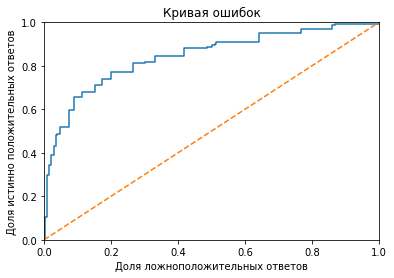

AUC-ROC: 0.8543017765194035


In [29]:
model = DecisionTreeClassifier(random_state=0, max_depth=best_depth_tree)
model.fit(features_ups, target_ups)
probabilities = model.predict_proba(features_valid)
proba_one_valid = probabilities[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, proba_one_valid)
plt.figure()
plt.step(fpr, tpr, where='post')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('Доля ложноположительных ответов')
plt.ylabel('Доля истинно положительных ответов')
plt.title('Кривая ошибок')
plt.show()
auc_roc_tree = roc_auc_score(target_valid, proba_one_valid)
print('AUC-ROC:', auc_roc_tree)

### Случайный лес

In [30]:
best_depth_forest, best_result_forest, best_est_forest = Forest(features_ups, target_ups, features_valid, target_valid)
print('Наилучшая F1-мера:', best_result_forest, 'с глубиной', best_depth_forest, 'и количеством деревьев', best_est_forest)

Наилучшая F1-мера: 0.6186186186186187 с глубиной 6 и количеством деревьев 25


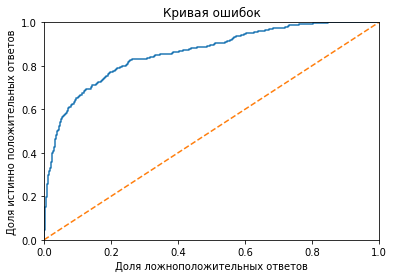

AUC-ROC: 0.8599917286638157


In [31]:
best_model = RandomForestClassifier(random_state=0, max_depth=best_depth_forest, n_estimators=best_est_forest)
best_model.fit(features_ups, target_ups)
probabilities = best_model.predict_proba(features_valid)
proba_one_valid = probabilities[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, proba_one_valid)
plt.figure()
plt.step(fpr, tpr, where='post')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('Доля ложноположительных ответов')
plt.ylabel('Доля истинно положительных ответов')
plt.title('Кривая ошибок')
plt.show()
auc_roc_forest = roc_auc_score(target_valid, proba_one_valid)
print('AUC-ROC:', auc_roc_forest)

### Логистическая регрессия

In [32]:
#создаем модель логистической регрессии
model = LogisticRegression(random_state=0, solver='liblinear')
#обучаем модель
model.fit(features_ups, target_ups)
#предсказываем результаты на валидационной выборке
predictions = model.predict(features_valid)
#рассчитываем F1-меру
result_logistic = f1_score(target_valid, predictions)
print('Наилучшая F1-мера:', result_logistic)#создаем модель логистической регрессии
model = LogisticRegression(random_state=0, solver='liblinear')
#обучаем модель
model.fit(features_ups, target_ups)
#предсказываем результаты на валидационной выборке
predictions = model.predict(features_valid)
#рассчитываем F1-меру
result_logistic = f1_score(target_valid, predictions)
print('Наилучшая F1-мера:', result_logistic)

Наилучшая F1-мера: 0.4073275862068965
Наилучшая F1-мера: 0.4073275862068965


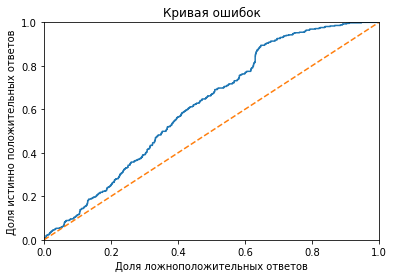

AUC-ROC: 0.6195155057255523


In [33]:
probabilities = model.predict_proba(features_valid)
proba_one_valid = probabilities[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, proba_one_valid)
plt.figure()
plt.step(fpr, tpr, where='post')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('Доля ложноположительных ответов')
plt.ylabel('Доля истинно положительных ответов')
plt.title('Кривая ошибок')
plt.show()
auc_roc_log = roc_auc_score(target_valid, proba_one_valid)
print('AUC-ROC:', auc_roc_log)

In [34]:
#создаем результирующую таблицу
final = pd.DataFrame(index=['Дерево решений', 'Случайный лес', 'Логистическая регрессия'], columns=['F1', 'AUC-ROC'])
final.loc['Дерево решений', 'F1'] = best_result_tree
final.loc['Дерево решений', 'AUC-ROC'] = auc_roc_tree
final.loc['Случайный лес', 'F1'] = best_result_forest
final.loc['Случайный лес', 'AUC-ROC'] = auc_roc_forest
final.loc['Логистическая регрессия', 'F1'] = result_logistic
final.loc['Логистическая регрессия', 'AUC-ROC'] = auc_roc_log

### Уменьшение выборки


* разделим обучающую выборку на отрицательные и положительные объекты

* отбрасываем часть отрицательных объектов

* с учетом полученных данных создадим новую выборку

* перемешаем данные


In [35]:
#функция downsampling
def downsample(features, target, frak):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    features_down = pd.concat([features_zeros.sample(frac=frak, random_state=0)]+[features_ones])
    target_down = pd.concat([target_zeros.sample(frac=frak, random_state=0)]+[target_ones])
    features_down, target_down = shuffle(features_down, target_down, random_state=0)
    return features_down, target_down

In [36]:
features_down, target_down = downsample(features_train, target_train, 0.25)

### Дерево решений

In [37]:
#рассчитаем F1-меру на дереве решений с увеличенной выборкой
best_depth_tree, best_result_tree, model_tree = Tree(features_down, target_down, features_valid, target_valid)
print('Наилучшая F1-мера:', best_result_tree, 'с глубиной', best_depth_tree)

Наилучшая F1-мера: 0.5743174924165825 с глубиной 5


### Случайный лес

In [38]:
best_depth_forest, best_result_forest, best_est_forest = Forest(features_down, target_down, features_valid, target_valid)
print('Наилучшая F1-мера:', best_result_forest, 'с глубиной', best_depth_forest, 'и количеством деревьев', best_est_forest)

Наилучшая F1-мера: 0.5743174924165825 с глубиной 5 и количеством деревьев 40


### Логистическая регрессия

In [39]:
#создаем модель логистической регрессии
model = LogisticRegression(random_state=0, solver='liblinear')
#обучаем модель
model.fit(features_down, target_down)
#предсказываем результаты на валидационной выборке
predictions = model.predict(features_valid)
#рассчитываем F1-меру
result_logistic = f1_score(target_valid, predictions)
print('Наилучшая F1-мера:', result_logistic)

Наилучшая F1-мера: 0.40774610005379236


### Вывод


Увеличение выборки позволило увеличить значение F1-меры и AUC-ROC. Наилучший результат показывает алгоритм случайного дерева, наихудший - логистическая регрессия.

На следующем этапе проверим адекватность выбранной модели на тестовой выборке.


In [40]:
final.head().style.highlight_max(color='yellowgreen', subset=['F1', 'AUC-ROC'])

,F1,AUC-ROC
Дерево решений,0.618619,0.854302
Случайный лес,0.618619,0.859992
Логистическая регрессия,0.407328,0.619516


[К оглавлению](#intro)

<a id='chapter6'></a>

# 4. Тестирование модели


На предыдущих этапах мы выяснили, что наилучшие показатели дает алгоритм случайного леса с количеством деревьев 25 и глубиной 6. Сейчас проверим, какую F1-меру даст этот алгоритм на тестовой выборке.


In [41]:
predictions = best_model.predict(features_test)
#рассчитываем значение F1
result = f1_score(target_test, predictions)
print('F1-мера на тестовой выборке:', result)

F1-мера на тестовой выборке: 0.5941343424787133


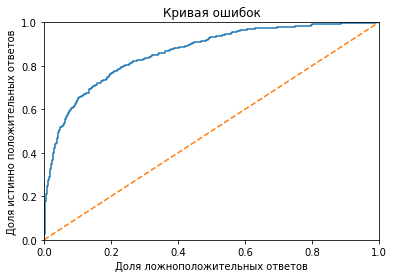

AUC-ROC: 0.8627996439490693


In [42]:
probabilities = best_model.predict_proba(features_test)
proba_one_valid = probabilities[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, proba_one_valid)
plt.figure()
plt.step(fpr, tpr, where='post')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('Доля ложноположительных ответов')
plt.ylabel('Доля истинно положительных ответов')
plt.title('Кривая ошибок')
plt.show()
auc_roc_forest = roc_auc_score(target_test, proba_one_valid)
print('AUC-ROC:', auc_roc_forest)

[К оглавлению](#intro)

<a id='chapter7'></a>

# Общий вывод


В данной работе мы изучили поведение клиентов "Бета-Банка" для создания модели, позволяющей спрогнозировать уход клиента из банка.

Изучая исходную информацию - кредитный рейтинг, страну проживания, количество недвижимости клиентов и прочее - мы построили несколько моделей, позволяющих определить целевой признак, а именно факт расторжения клиентом договора с банком.

Мы построили модели:

* дерева решений с различными значениями глубины дерева

* случайного леса с варьирующимися значениями количества деревьев и глубины

* логистической регрессии

Также мы проанализировали несколько способов борьбы с дисбалансом классом: увеличение выборки редкого класса и уменьшение выборки часто встречающегося класса.

На валидационной выборке наибольшее значение F1-меры показал алгоритм случайного леса с глубиной 6 и количеством деревьев 25, а также с учетом увеличения выборки редкого класса. Поэтому именно эту модель мы применили к тестовой выборке, на которой значение F1-меры было равно 0.59, что является хорошим результатом.

А значит мы можем использовать данную модель для прогноза ухода клиентов из банка.

[К оглавлению](#intro)